In [29]:
from collections import defaultdict
import random
import numpy as np
import pandas as pd
import itertools

In [16]:
def discrete_convolution(distribution, n):
    """
    Calcola la distribuzione di probabilità discreta dopo n giorni.
    
    :param distribution: Dizionario con la distribuzione iniziale {valore: probabilità}
    :param n: Numero di giorni
    :return: Dizionario con la distribuzione finale dopo n giorni
    """
    
    current_distribution = distribution
    
    for _ in range(n - 1):
        new_distribution = defaultdict(float)
        
        for (value1, prob1) in current_distribution.items():
            for (value2, prob2) in distribution.items():
                new_value = value1 * value2
                new_prob = prob1 * prob2
                new_distribution[new_value] += new_prob
                
        current_distribution = new_distribution
        
    return current_distribution

# Esempio di utilizzo
initial_distribution = {
    2: 0.5,
    0.5: 0.5
}

n_days = 3
final_distribution = discrete_convolution(initial_distribution, n_days)

# Stampa il risultato
for value, prob in sorted(final_distribution.items()):
    print(f"Value: {value}, Probability: {prob}")

Value: 0.125, Probability: 0.125
Value: 0.5, Probability: 0.375
Value: 2.0, Probability: 0.375
Value: 8, Probability: 0.125


In [17]:
acc=0
for value, prob in sorted(final_distribution.items()):
    acc += value*prob
acc

1.953125

In [18]:
random.choices([1/3, 2], [0.9, 0.1], k=10)

[0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 2,
 0.3333333333333333,
 0.3333333333333333]

In [19]:
def create_dataframe(prices):
    """
    Crea un DataFrame con le colonne 'Price' e 'Timestamp' dai dati dei prezzi.
    
    :param prices: Lista dei prezzi giornalieri
    :return: DataFrame con colonne 'Price' e 'Timestamp'
    """
    dates = pd.date_range(start='2000-01-01', periods=len(prices), freq='D')
    df = pd.DataFrame({'Price': prices, 'Timestamp': dates})
    return df

In [20]:
def trading_strategy(prices):
    """
    Strategia di trading: compra 100% nei giorni dispari e vendi 100% nei giorni pari.
    
    :param prices: Lista dei prezzi giornalieri
    :return: Lista dei valori del portafoglio totale nel tempo
    """
    portfolio_value = 1.0  # Iniziamo con un valore di portafoglio di 1 unità
    tokens = 0.0
    cash = portfolio_value
    portfolio_values = []

    for day, price in enumerate(prices):
        if day % 2 == 0:  # Giorni pari: vendi tutto
            cash += tokens * price
            tokens = 0.0
        else:  # Giorni dispari: compra tutto
            tokens += cash / price
            cash = 0.0
        portfolio_value = cash + tokens * price
        portfolio_values.append(portfolio_value)
    
    return portfolio_values

In [21]:
def trading_strategy2(prices):
    dati = create_dataframe(prices)

    
    # Inizializzazione delle variabili
    liquidita_mobile_iniziale = 1000
    liquidita_fissa_iniziale = 10**9
    bitcoin_iniziali = 0
    perc_primo_acquisto = 0.01
    vendita_immediata = False
    perc_sbilanciamento_acquisto = 7/10
    perc_commissione_acquisto = 0.001
    perc_commissione_vendita = 0.001
    min_acquisto = 5
    min_vendita = 5
    soglia_minima_vendita = 0 # Percentuale minima di cui il prezzo dev'essere sopra alla media pesata di acquisto per poter vendere
    perc_stop_loss = 0 # Utile solo in caso di vendita_immediata = False: per vendere, l'algoritmo aspetta che il prezzo scenda almeno di una percentuale perc_stop_loss rispetto al massimo mai raggiunto durante una salita (se vende in questo modo, viene ricalcolato da capo da lì in poi; si aggiorna solo durante le salite, non durante le discese); se perc_stop_loss = 0, semplicemente vende non appena il prezzo scende rispetto al massimo

    liquidita_mobile = liquidita_mobile_iniziale
    liquidita_fissa = liquidita_fissa_iniziale
    bitcoin = bitcoin_iniziali

    ultima_azione_effettiva = None
    ultimi_acquisti = []
    transazioni = pd.DataFrame(columns=['Data', 'Numero giorno', 'Prezzo', 'Ultima Azione', 'Azione Attuale', '% acquisto/vendita di LM', 'Quantità in € Comprata/Venduta', 'Quantità di Bitcoin Comprati/Venduti', 'Liquidità Mobile', 'Liquidità Fissa', 'Bitcoin Posseduti', 'Valore Totale del Portafoglio'])
    giorni_acquisto = []
    giorni_vendita = []

    prezzo_massimo = 0
    in_salita = False

    def aggiorna_transazioni(i, azione, perc, quantita_euro, quantita_btc):
        nonlocal transazioni, liquidita_mobile, liquidita_fissa, bitcoin, ultima_azione_effettiva # La parola chiave nonlocal viene utilizzata per dichiarare che una variabile all'interno di una funzione nidificata (una funzione definita all'interno di un'altra funzione) si riferisce a una variabile definita nel contesto della funzione esterna (non globale, ma nemmeno locale alla funzione corrente); dovrei usare invece "global" se questa function fosse definita a livello globale e non all'interno di un'altra function
        ultima_azione = ultima_azione_effettiva if ultima_azione_effettiva else "-"
        nuova_transazione = pd.DataFrame({
            'Data': [dati['Timestamp'].iloc[i]],
            'Numero giorno': i,
            'Prezzo': [dati['Price'].iloc[i]],
            'Ultima Azione': [ultima_azione],
            'Azione Attuale': [azione],
            '% acquisto/vendita di LM': [perc],
            'Quantità in € Comprata/Venduta': [quantita_euro],
            'Quantità di Bitcoin Comprati/Venduti': [quantita_btc],
            'Liquidità Mobile': [liquidita_mobile],
            'Liquidità Fissa': [liquidita_fissa],
            'Bitcoin Posseduti': [bitcoin],
            'Valore Totale del Portafoglio': [liquidita_mobile + liquidita_fissa + bitcoin * dati['Price'].iloc[i]]
        })
        transazioni = pd.concat([transazioni, nuova_transazione], ignore_index=True)
        if azione != "-":
            ultima_azione_effettiva = azione

    def primo_acquisto(i):
        nonlocal liquidita_mobile, bitcoin, ultimi_acquisti
        quantita_primo_acquisto = liquidita_mobile * perc_primo_acquisto
        bitcoin_acquistati = quantita_primo_acquisto / dati['Price'].iloc[i] * (1 - perc_commissione_acquisto)
        liquidita_mobile -= quantita_primo_acquisto
        bitcoin += bitcoin_acquistati
        ultimi_acquisti = [(dati['Price'].iloc[i], quantita_primo_acquisto)]
        giorni_acquisto.append(i)
        aggiorna_transazioni(i, 'Primo Acquisto', perc_primo_acquisto, quantita_primo_acquisto, bitcoin_acquistati)

    def calcola_prezzo_medio_pesato():
        return sum([euro*prezzo for prezzo, euro in ultimi_acquisti]) / sum([euro for _ , euro in ultimi_acquisti])

    # Primo acquisto al giorno 1
    primo_acquisto(1)

    for i in range(2, len(dati)):
        prezzo_oggi = dati['Price'].iloc[i]
        prezzo_ieri = dati['Price'].iloc[i-1]
        prezzo_laltro_ieri = dati['Price'].iloc[i-2]
        azione = "-"  # Inizializziamo l'azione come nulla
        
        if bitcoin > 0:
            prezzo_medio_pesato = calcola_prezzo_medio_pesato()
            
            # Aggiorna il prezzo massimo se siamo in una salita
            if prezzo_oggi > prezzo_ieri:
                in_salita = True
                if prezzo_ieri < prezzo_laltro_ieri:
                    prezzo_massimo = 0  # Reset del prezzo massimo se il giorno precedente è finita una discesa
                prezzo_massimo = max(prezzo_massimo, prezzo_oggi)
            else:
                in_salita = False
            
            if vendita_immediata:
                if prezzo_oggi > prezzo_medio_pesato * (1 + soglia_minima_vendita):
                    # Vendita immediata
                    quantita_venduta = bitcoin
                    ricavo = quantita_venduta * prezzo_oggi * (1 - perc_commissione_vendita)
                    if ricavo >= min_vendita:
                        liquidita_mobile += ricavo
                        bitcoin = 0
                        giorni_vendita.append(i)
                        azione = 'Vendita'
                        aggiorna_transazioni(i, azione, 1, ricavo, quantita_venduta)
                        # print(sum([b for _, b in ultimi_acquisti]), ricavo, ricavo/sum([b for _, b in ultimi_acquisti]))
                        ultimi_acquisti = []
            else:
                if not in_salita and prezzo_oggi <= prezzo_massimo * (1 - perc_stop_loss) and prezzo_oggi > prezzo_medio_pesato * (1 + soglia_minima_vendita):
                    # Vendita con stop-loss
                    quantita_venduta = bitcoin
                    ricavo = quantita_venduta * prezzo_oggi * (1 - perc_commissione_vendita)
                    if ricavo >= min_vendita:
                        liquidita_mobile += ricavo
                        bitcoin = 0
                        giorni_vendita.append(i)
                        azione = 'Vendita (Stop-Loss)'
                        aggiorna_transazioni(i, azione, 1, ricavo, quantita_venduta)
                        # print(sum([b for _, b in ultimi_acquisti]), ricavo, ricavo/sum([b for _, b in ultimi_acquisti]), bitcoin*dati['Price'].iloc[i] + liquidita_mobile + liquidita_fissa)
                        ultimi_acquisti = []
        
        if azione != 'Vendita' and azione != 'Vendita (Stop-Loss)':  # Se non abbiamo venduto, consideriamo l'acquisto
            if not ultimi_acquisti:
                if prezzo_oggi < prezzo_ieri:
                    # Primo acquisto dopo una vendita
                    primo_acquisto(i)
                    azione = 'Primo Acquisto'
                    # prezzo_massimo = prezzo_oggi  # Inizializzo il prezzo massimo
            elif prezzo_oggi < ultimi_acquisti[-1][0]:
                # Calcolo del prezzo desiderato di acquisto
                ultimo_prezzo_acquisto = ultimi_acquisti[-1][0]
                A = perc_sbilanciamento_acquisto * prezzo_oggi + (1 - perc_sbilanciamento_acquisto) * ultimo_prezzo_acquisto # Prezzo a cui si vuole imporre la media pesata

                # Calcolo della quantità da acquistare
                S = sum([p * q for p, q in ultimi_acquisti])  # Questa è la somma pesata degli ultimi acquisti
                P = sum([q for _, q in ultimi_acquisti])  # Questa è la somma delle spese degli ultimi acquisti, cioè la somma dei pesi
                quantita_da_acquistare_euro = (S - A * P) / (A - prezzo_oggi)

                if quantita_da_acquistare_euro >= min_acquisto:
                    if quantita_da_acquistare_euro > liquidita_mobile:
                        # Usa la liquidità fissa se necessario
                        liquidita_aggiuntiva = min(liquidita_fissa, quantita_da_acquistare_euro - liquidita_mobile)
                        liquidita_mobile += liquidita_aggiuntiva
                        liquidita_fissa -= liquidita_aggiuntiva

                    if quantita_da_acquistare_euro <= liquidita_mobile:
                        # Acquisto
                        bitcoin_acquistati = quantita_da_acquistare_euro / prezzo_oggi * (1 - perc_commissione_acquisto)
                        vecchia_liquidita_mobile = liquidita_mobile
                        liquidita_mobile -= quantita_da_acquistare_euro
                        bitcoin += bitcoin_acquistati
                        ultimi_acquisti.append((prezzo_oggi, quantita_da_acquistare_euro))  # Ora memorizzo gli euro spesi invece dei bitcoin acquistati
                        giorni_acquisto.append(i)
                        azione = 'Acquisto'
                        aggiorna_transazioni(i, azione, quantita_da_acquistare_euro / vecchia_liquidita_mobile, quantita_da_acquistare_euro, bitcoin_acquistati)
        
        if azione == "-":
            # Se non è stata effettuata nessuna azione, aggiungo comunque una riga alla tabella
            aggiorna_transazioni(i, azione, 0, 0, 0)

    return list(transazioni['Valore Totale del Portafoglio'])

In [22]:
random.choices([1/3, 2], [0.5, 0.5], k=1)[0]

2

In [27]:
def simulate_price_changes(distribution, n_days):
    """
    Simula le variazioni dei prezzi per un dato numero di giorni basandosi sulla distribuzione di probabilità.
    
    :param distribution: Dizionario {variazione: probabilità}
    :param n_days: Numero di giorni della simulazione
    :return: Lista dei prezzi simulati per ogni giorno
    """
    variations = list(distribution.keys())
    probabilities = list(distribution.values())
    price = 100000  # Prezzo iniziale
    prices = [price]

    for _ in range(n_days):
        daily_change = random.choices(variations, probabilities, k=1)[0]
        price *= daily_change
        prices.append(price)
    
    return prices

# def trading_strategy(prices):
#     """
#     Strategia di trading: compra 100% nei giorni dispari e vendi 100% nei giorni pari.
    
#     :param prices: Lista dei prezzi giornalieri
#     :return: Lista dei valori del portafoglio totale nel tempo
#     """
#     portfolio_value = 1.0  # Iniziamo con un valore di portafoglio di 1 unità
#     tokens = 0.0
#     cash = portfolio_value
#     portfolio_values = []

#     for day, price in enumerate(prices):
#         if day % 2 == 0:  # Giorni pari: vendi tutto
#             cash += tokens * price
#             tokens = 0.0
#         else:  # Giorni dispari: compra tutto
#             tokens += cash / price
#             cash = 0.0
#         portfolio_value = cash + tokens * price
#         portfolio_values.append(portfolio_value)
    
#     return portfolio_values

def run_simulations(n_simulations, n_days, distribution):
    """
    Esegue n_simulazioni della strategia di trading per n_days giorni e calcola il valore medio del portafoglio finale.
    
    :param n_simulations: Numero di simulazioni
    :param n_days: Numero di giorni per ogni simulazione
    :param distribution: Dizionario {variazione: probabilità}
    :return: Valore medio del portafoglio finale dopo tutte le simulazioni
    """
    return_portfolio_values = []

    for _ in range(n_simulations):
        prices = simulate_price_changes(distribution, n_days)
        portfolio_values = trading_strategy(prices)
        return_portfolio_values.append(portfolio_values[-1]/portfolio_values[0])
    
    mean_return_value = np.mean(return_portfolio_values)
    return mean_return_value

# Esempio di utilizzo
initial_distribution = {
    2: 0.5,
    0.5: 0.5
}

n_simulations = 1000
n_days = 10

mean_return_portfolio_value = run_simulations(n_simulations, n_days, initial_distribution)
print(f"Valore medio del portafoglio finale dopo {n_simulations} simulazioni: {mean_return_portfolio_value}")

Valore medio del portafoglio finale dopo 1000 simulazioni: 2.93375


In [28]:
print(f"Valore medio del rendimento dopo {n_simulations} simulazioni: {mean_return_portfolio_value}")

Valore medio del rendimento dopo 1000 simulazioni: 2.93375


In [45]:
# Distribuzione di probabilità delle variazioni percentuali del prezzo
price_changes = {
    2.0: 0.5,
    0.5: 0.5
}

# Controllo della somma delle probabilità
if sum(price_changes.values()) != 1.0:
    raise ValueError("La somma delle probabilità delle variazioni percentuali del prezzo deve essere 1.")

# Azioni di trading possibili
actions = {
    "buy": [0.5, 1.0],  # percentuale di liquidità per comprare
    "hold": [],         # nessuna azione
    "sell": [0.5, 1.0]  # percentuale di token per vendere
}

# Variabili di configurazione
initial_liquidity = 1000
initial_tokens = 0
num_days = 3
initial_price = 500

# Generare tutte le possibili combinazioni delle variazioni di prezzo per i giorni di trading
price_trajectories = list(itertools.product(price_changes.keys(), repeat=num_days))

# Funzione per calcolare il valore finale per una data strategia e una data traiettoria di prezzo
def simulate_trading_strategy(strategy, trajectory):
    liquidity = initial_liquidity
    tokens = initial_tokens
    price = initial_price  # Prezzo iniziale del token
    transactions = []

    last_action = "hold"

    for day, (action, change) in enumerate(zip(strategy, trajectory)):
        buy_amount = 0
        sell_amount = 0
        buy_percent = "-"
        sell_percent = "-"

        if action[0] == "buy":
            buy_amount = liquidity * action[1]
            tokens += buy_amount / price
            liquidity -= buy_amount
            buy_percent = action[1]
            last_action = "buy"
        elif action[0] == "sell":
            sell_amount = tokens * action[1]
            liquidity += sell_amount * price
            tokens -= sell_amount
            sell_percent = action[1]
            last_action = "sell"

        # Aggiornamento del prezzo in base alla traiettoria
        price *= change

        # Aggiungere la transazione alla tabella
        transactions.append({
            "data": day + 1,
            "prezzo del giorno": price / change,
            "azione compiuta": action[0],
            "ultima azione compiuta": last_action,
            "quantità di soldi acquistati/venduti": buy_amount if action[0] == "buy" else sell_amount*price,
            "quantità di token acquistati/venduti": buy_amount / price if action[0] == "buy" else sell_amount,
            "percentuale di soldi acquistati": buy_percent,
            "percentuale di token venduti": sell_percent,
            "liquidità posseduta": liquidity,
            "token posseduti": tokens,
            "portafoglio totale": liquidity + tokens * price
        })

    # Valore finale combinato di liquidità e token
    final_value = liquidity + tokens * price
    return final_value, transactions

# Generare tutte le possibili combinazioni di strategie di trading
action_combinations = []
for _ in range(num_days):
    day_actions = []
    for action, percentages in actions.items():
        if action == "hold":
            day_actions.append((action, 0))
        else:
            for percentage in percentages:
                day_actions.append((action, percentage))
    action_combinations.append(day_actions)

all_strategies = list(itertools.product(*action_combinations))

# Filtrare combinazioni non valide (ad es. "hold" con percentuale diversa da 0)
# valid_strategies = []
# for strategy in all_strategies:
#     valid = True
#     for action in strategy:
#         if action[0] == "hold" and action[1] != 0:
#             valid = False
#             break
#     if valid:
#         valid_strategies.append(strategy)

# Determinare la strategia con il valore atteso massimo
max_value = -float("inf")
best_strategy = None
best_transactions = None

for strategy in all_strategies:
    total_value = 0
    strategy_transactions = []

    for trajectory in price_trajectories:
        prob = 1
        for change in trajectory:
            prob *= price_changes[change]
        final_value, transactions = simulate_trading_strategy(strategy, trajectory)
        total_value += final_value * prob
        strategy_transactions.append(transactions)

    expected_value = total_value
    print(f"Strategia testata: {strategy}\nFattore di rendimento: {expected_value / initial_liquidity:.2f}")

    if expected_value > max_value:
        max_value = expected_value
        best_strategy = strategy
        best_transactions = strategy_transactions

    print(f"\nLa migliore strategia di trading trovata finora è: {best_strategy}")
    print(f"Il valore atteso massimo trovato finora per il portafoglio finale è: {max_value:.2f}€, con un rendimento di {max_value/(initial_liquidity+initial_tokens*initial_price):.2f}\n\n")

# Mostrare le tabelle delle transazioni per la strategia migliore
for i, transactions in enumerate(best_transactions):
    df = pd.DataFrame(transactions)
    print('Tabelle con le transazioni avvenute usando la strategia migliore trovata:\n')
    print(f"Andamento del prezzo {i+1}: {price_trajectories[i]}")
    print(df.to_string(index=False))
    print()

Strategia testata: (('buy', 0.5), ('buy', 0.5), ('buy', 0.5))
Fattore di rendimento: 1.65

La migliore strategia di trading trovata finora è: (('buy', 0.5), ('buy', 0.5), ('buy', 0.5))
Il valore atteso massimo trovato finora per il portafoglio finale è: 1648.44€, con un rendimento di 1.65


Strategia testata: (('buy', 0.5), ('buy', 0.5), ('buy', 1.0))
Fattore di rendimento: 1.68

La migliore strategia di trading trovata finora è: (('buy', 0.5), ('buy', 0.5), ('buy', 1.0))
Il valore atteso massimo trovato finora per il portafoglio finale è: 1679.69€, con un rendimento di 1.68


Strategia testata: (('buy', 0.5), ('buy', 0.5), ('hold', 0))
Fattore di rendimento: 1.62

La migliore strategia di trading trovata finora è: (('buy', 0.5), ('buy', 0.5), ('buy', 1.0))
Il valore atteso massimo trovato finora per il portafoglio finale è: 1679.69€, con un rendimento di 1.68


Strategia testata: (('buy', 0.5), ('buy', 0.5), ('sell', 0.5))
Fattore di rendimento: 1.48

La migliore strategia di trading 

In [42]:
np.mean([8000, 2000, 2000, 500, 2000, 500, 500, 125])

1953.125

In [46]:
# Distribuzione di probabilità delle variazioni percentuali del prezzo
price_changes = {
    2.0: 0.5,
    0.5: 0.5
}

# Controllo della somma delle probabilità
if sum(price_changes.values()) != 1.0:
    raise ValueError("La somma delle probabilità delle variazioni percentuali del prezzo deve essere 1.")

# Azioni di trading possibili
actions = {
    "buy": [0.5, 1.0],  # percentuale di liquidità per comprare
    "hold": [],         # nessuna azione
    "sell": [0.5, 1.0]  # percentuale di token per vendere
}

# Variabili di configurazione
initial_liquidity = 1000
initial_tokens = 0
num_days = 3
initial_price = 500

# Generare tutte le possibili combinazioni delle variazioni di prezzo per i giorni di trading
price_trajectories = list(itertools.product(price_changes.keys(), repeat=num_days))

# Funzione per calcolare il valore finale per una data strategia e una data traiettoria di prezzo
def simulate_trading_strategy(strategy, trajectory):
    liquidity = initial_liquidity
    tokens = initial_tokens
    price = initial_price  # Prezzo iniziale del token
    transactions = []

    last_action = "hold"

    for day, (action, change) in enumerate(zip(strategy, trajectory)):
        buy_amount = 0
        sell_amount = 0
        buy_percent = "-"
        sell_percent = "-"

        # Controllo se l'azione è valida
        if action[0] == "buy" and liquidity > 0:
            buy_amount = liquidity * action[1]
            tokens += buy_amount / price
            liquidity -= buy_amount
            buy_percent = action[1]
            last_action = "buy"
        elif action[0] == "sell" and tokens > 0:
            sell_amount = tokens * action[1]
            liquidity += sell_amount * price
            tokens -= sell_amount
            sell_percent = action[1]
            last_action = "sell"
        else:
            action = ("hold", 0)
            last_action = last_action if last_action != "hold" else "hold"

        # Aggiornamento del prezzo in base alla traiettoria
        price *= change

        # Aggiungere la transazione alla tabella
        transactions.append({
            "data": day + 1,
            "prezzo del giorno": price / change,
            "azione compiuta": action[0],
            "ultima azione compiuta": last_action,
            "quantità di soldi acquistati/venduti": buy_amount if action[0] == "buy" else sell_amount * price,
            "quantità di token acquistati/venduti": buy_amount / price if action[0] == "buy" else sell_amount,
            "percentuale di soldi acquistati": buy_percent,
            "percentuale di token venduti": sell_percent,
            "liquidità posseduta": liquidity,
            "token posseduti": tokens,
            "portafoglio totale": liquidity + tokens * price
        })

    # Valore finale combinato di liquidità e token
    final_value = liquidity + tokens * price
    return final_value, transactions

# Generare tutte le possibili combinazioni di strategie di trading
action_combinations = []
for _ in range(num_days):
    day_actions = []
    for action, percentages in actions.items():
        if action == "hold":
            day_actions.append((action, 0))
        else:
            for percentage in percentages:
                day_actions.append((action, percentage))
    action_combinations.append(day_actions)

all_strategies = list(itertools.product(*action_combinations))

# Determinare la strategia con il valore atteso massimo
max_value = -float("inf")
best_strategy = None
best_transactions = None

for strategy in all_strategies:
    total_value = 0
    strategy_transactions = []

    for trajectory in price_trajectories:
        prob = 1
        for change in trajectory:
            prob *= price_changes[change]
        final_value, transactions = simulate_trading_strategy(strategy, trajectory)
        total_value += final_value * prob
        strategy_transactions.append(transactions)

    expected_value = total_value
    print(f"Strategia testata: {strategy}\nFattore di rendimento: {expected_value / initial_liquidity:.2f}")

    if expected_value > max_value:
        max_value = expected_value
        best_strategy = strategy
        best_transactions = strategy_transactions

    print(f"\nLa migliore strategia di trading trovata finora è: {best_strategy}")
    print(f"Il valore atteso massimo trovato finora per il portafoglio finale è: {max_value:.2f}€, con un rendimento di {max_value/(initial_liquidity+initial_tokens*initial_price):.2f}\n\n")

# Mostrare le tabelle delle transazioni per la strategia migliore
for i, transactions in enumerate(best_transactions):
    df = pd.DataFrame(transactions)
    print('Tabelle con le transazioni avvenute usando la strategia migliore trovata:\n')
    print(f"Andamento del prezzo {i+1}: {price_trajectories[i]}")
    print(df.to_string(index=False))
    print()

Strategia testata: (('buy', 0.5), ('buy', 0.5), ('buy', 0.5))
Fattore di rendimento: 1.65

La migliore strategia di trading trovata finora è: (('buy', 0.5), ('buy', 0.5), ('buy', 0.5))
Il valore atteso massimo trovato finora per il portafoglio finale è: 1648.44€, con un rendimento di 1.65


Strategia testata: (('buy', 0.5), ('buy', 0.5), ('buy', 1.0))
Fattore di rendimento: 1.68

La migliore strategia di trading trovata finora è: (('buy', 0.5), ('buy', 0.5), ('buy', 1.0))
Il valore atteso massimo trovato finora per il portafoglio finale è: 1679.69€, con un rendimento di 1.68


Strategia testata: (('buy', 0.5), ('buy', 0.5), ('hold', 0))
Fattore di rendimento: 1.62

La migliore strategia di trading trovata finora è: (('buy', 0.5), ('buy', 0.5), ('buy', 1.0))
Il valore atteso massimo trovato finora per il portafoglio finale è: 1679.69€, con un rendimento di 1.68


Strategia testata: (('buy', 0.5), ('buy', 0.5), ('sell', 0.5))
Fattore di rendimento: 1.48

La migliore strategia di trading 

### Andamento del prezzo medio a partire dalla distribuzione di probabilità delle variazioni di prezzo, il prezzo iniziale e il numero di giorni

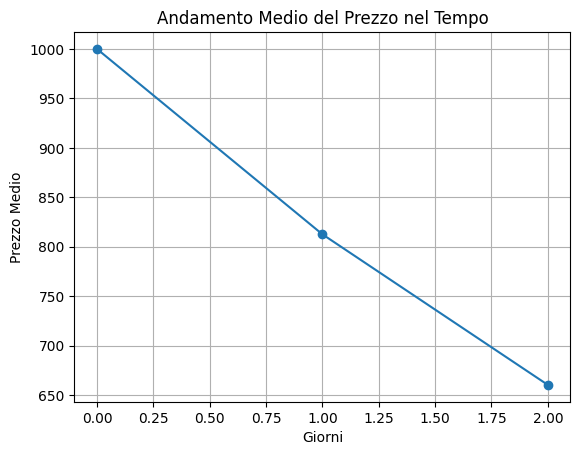

In [55]:
# Distribuzione di probabilità delle variazioni percentuali del prezzo
price_changes = {
    1.5: 0.5,
    1/8: 0.5
}

# Controllo della somma delle probabilità
if sum(price_changes.values()) != 1.0:
    raise ValueError("La somma delle probabilità delle variazioni percentuali del prezzo deve essere 1.")

# Variabili di configurazione
initial_price = 1000
num_days = 2

# Generare tutte le possibili combinazioni delle variazioni di prezzo per i giorni di trading
price_trajectories = list(itertools.product(price_changes.keys(), repeat=num_days))

# Calcolare l'andamento medio del prezzo per ogni giorno
average_prices = [initial_price] * num_days

for day in range(num_days):
    total_price = 0
    for trajectory in price_trajectories:
        price = initial_price
        for t in range(day + 1):
            price *= trajectory[t]
        total_price += price
    average_prices[day] = total_price / len(price_trajectories)

# Aggiungere il prezzo iniziale alla lista per il plot
average_prices = [initial_price] + average_prices

# Plot dell'andamento medio del prezzo
days = list(range(len(average_prices)))
plt.plot(days, average_prices, marker='o')
plt.xlabel('Giorni')
plt.ylabel('Prezzo Medio')
plt.title('Andamento Medio del Prezzo nel Tempo')
plt.grid(True)
plt.show()

In [56]:
average_prices

[1000, 812.5, 660.15625]

#### Stesso discorso ma sui dati di BTC

In [75]:
dati_btc = pd.read_csv('Bitcoin (€) da yfinance dal 17-09-2014 al 24-04-2024.csv')[['Close']]
dati_btc

,Close
0,355.957367
1,328.539368
2,307.761139
3,318.758972
4,310.632446
...,...
3503,59876.710938
3504,60956.074219
3505,60919.242188
3506,62729.296875


In [76]:
# Calcolare le variazioni percentuali giornaliere
dati_btc['price_change'] = dati_btc['Close'].pct_change()

# Rimuovere i valori NaN iniziali dovuti alla differenza percentuale
dati_btc = dati_btc.dropna()

# Costruire il dizionario delle variazioni percentuali con le loro probabilità
price_changes_dict = defaultdict(int)
total_changes = len(dati_btc['price_change'])

# Popolare il dizionario con la frequenza delle variazioni percentuali
for change in dati_btc['price_change']:
    if not np.isnan(change):  # Filtra le chiavi NaN
        price_changes_dict[change] += 1

# Convertire le frequenze in probabilità
price_changes = {change: count / total_changes for change, count in price_changes_dict.items()}

# Stampa il dizionario delle variazioni percentuali con le loro probabilità
price_changes

{-0.07702607619282942: 0.00028514399771884804,
 -0.06324425869191608: 0.00028514399771884804,
 0.0357349641045952: 0.00028514399771884804,
 -0.025494265537485794: 0.00028514399771884804,
 0.007488993795341736: 0.00028514399771884804,
 0.08381611253713173: 0.00028514399771884804,
 -0.023408013085526425: 0.00028514399771884804,
 -0.025881946491745245: 0.00028514399771884804,
 -0.011713754816655708: 0.00028514399771884804,
 -0.012128297203762184: 0.00028514399771884804,
 -0.055393186937438776: 0.00028514399771884804,
 -0.005642566617636069: 0.00028514399771884804,
 0.03554544650093172: 0.00028514399771884804,
 -0.008053432195084587: 0.00028514399771884804,
 -0.025974148544362086: 0.00028514399771884804,
 -0.029690671022998605: 0.00028514399771884804,
 -0.08524327014653521: 0.00028514399771884804,
 -0.025174863994670837: 0.00028514399771884804,
 0.01918484083537142: 0.00028514399771884804,
 0.016976243592163875: 0.00028514399771884804,
 0.04340481916133743: 0.00028514399771884804,
 0.03856

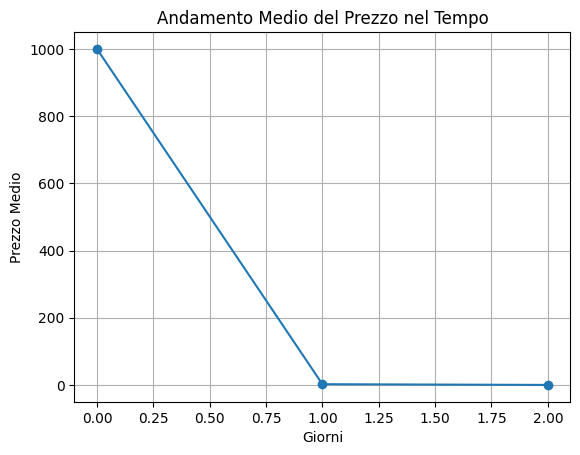

In [77]:
# Controllo della somma delle probabilità
# if sum(price_changes.values()) != 1.0:
#     raise ValueError("La somma delle probabilità delle variazioni percentuali del prezzo deve essere 1.")

# Variabili di configurazione
initial_price = 1000
num_days = 2

# Generare tutte le possibili combinazioni delle variazioni di prezzo per i giorni di trading
price_trajectories = list(itertools.product(price_changes.keys(), repeat=num_days))

# Calcolare l'andamento medio del prezzo per ogni giorno
average_prices = [initial_price] * num_days

for day in range(num_days):
    total_price = 0
    for trajectory in price_trajectories:
        price = initial_price
        for t in range(day + 1):
            price *= trajectory[t]
        total_price += price
    average_prices[day] = total_price / len(price_trajectories)

# Aggiungere il prezzo iniziale alla lista per il plot
average_prices = [initial_price] + average_prices

# Plot dell'andamento medio del prezzo
days = list(range(len(average_prices)))
plt.plot(days, average_prices, marker='o')
plt.xlabel('Giorni')
plt.ylabel('Prezzo Medio')
plt.title('Andamento Medio del Prezzo nel Tempo')
plt.grid(True)
plt.show()